<a href="https://colab.research.google.com/github/dphi-official/Deep_Learning_Bootcamp/blob/master/Assignment2_Help_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Learning Objectives**





*   Ways to fetch image data
*   Ways to load image data




## **Fetching Image Data**

We can fetch data in one of the following ways:

1.   Download from shared google drive link
2.   Accessing data from our own google drive
3.   If the dataset is loaded on Kaggle, we can access it through Kaggle APIs (ignore this step if you are not familiar with kaggle, you can save it to your bucketlist for later)



### 1. Download from shared google drive link

1. Download from shared google drive link <br>
Ex: https://drive.google.com/file/d/176E-pLhoxTgWsJ3MeoJQV_GXczIA6g8D/view?usp=sharing <br>
Copy file id from the link : 176E-pLhoxTgWsJ3MeoJQV_GXczIA6g8D

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='176E-pLhoxTgWsJ3MeoJQV_GXczIA6g8D',
                                    dest_path='/content/animals.zip',
                                    unzip=True)

Unzipping...Done.


### 2. Accessing data from our own google drive

In [ ]:
#mounts the google drive
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
#copy the data from drive to colab. Copying a saved model from gdrive to colab.
!mkdir 'models1/'
!cp '/content/drive/My Drive/PneumoniaClassifier_final_22Mar.pt' '/models1/'

### 3. Access data from kaggle using kaggle API <br>

Click on top right profile icon in your kaggle account and go to My Acccount. <br>
Scroll down until you see api details
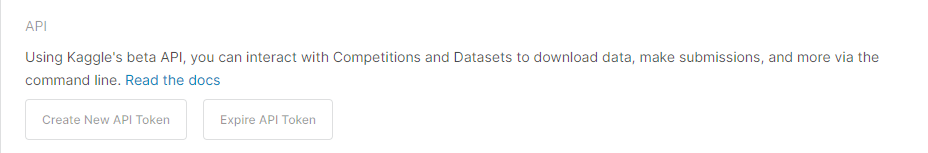 <br>

Click on Create New API Token and save the generated kaggle.json in drive.

In [ ]:
!pip install kaggle
import json
!mkdir .kaggle

#Enter your kaggle username and api token
!cp '/content/drive/My Drive/kaggle.json' ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list -s 'cats'

In [ ]:
!kaggle datasets download -d chetankv/dogs-cats-images -p /content --force

 98% 427M/435M [00:12<00:00, 53.6MB/s]
100% 435M/435M [00:12<00:00, 37.7MB/s]


In [ ]:
!unzip dogs-cats-images.zip

## Loading & Pre-processing image data

Loading and pre-processing an image dataset can be done in one of the following ways:



1.   Without any help from tensorflow/keras (using CV)
2.   Using: tf.keras.preprocessing.image_dataset_from_directory
3.   Using ImageData generators to load data

#### What & Why Data Augmentation

Pre-processing steps involve Data Augmentation which is nothing but cropping, re-sizing image, flipping an image horizontal/vertically, zooming etc.

Through Data Augmentation, you can create synthentic data i.e different versions of same image (Eg: zoomed picture, horizontally flipped image etc) and train a neural network. This indirectly provides more data to neural networks allowing them to learn and perform better.

Refer this meme: https://www.instagram.com/p/CErANi_HjVb/



### Method 1: Without any help from tensorflow/keras (Using CV)

In [ ]:
#importing necessary libraries
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
class_names = ['cats','dogs']
IMG_SIZE = 224

In [ ]:
#read the data from a directory
def get_data_from_folder(path):
  data = []
  for class_name in class_names: # iterate through classes
    try:
      files = glob.glob(path+"/"+class_name+"/*") # get files in each folder(class)
      for f in files:
        img = cv2.imread(f) #read the image
        img = cv2.resize(img,(IMG_SIZE,IMG_SIZE)) #resize the image
        data.append([np.array(img),class_names.index(class_name)]) #Append images and corresponding labels to data
    except:
      pass
  np.random.shuffle(data)
  return data

In [ ]:
training_data = get_data_from_folder('dataset/training_set')
testing_data = get_data_from_folder('dataset/testing_set')

### Method 2: **Using**: tf.keras.preprocessing.**image_dataset_from_directory**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

image_size = (224, 224)
batch_size = 32

train_ds = image_dataset_from_directory(
    "dataset/training_set",
    labels = "inferred",
    label_mode = 'int',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds =image_dataset_from_directory(
    "dataset/training_set",
    labels = "inferred",
    label_mode = 'int',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 8000 files belonging to 2 classes.
Using 6400 files for training.
Found 8000 files belonging to 2 classes.
Using 1600 files for validation.


In [ ]:
test_ds = image_dataset_from_directory(
    "dataset/test_set",
    labels = "inferred",
    label_mode = 'int',
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2000 files belonging to 2 classes.


In [ ]:
#visualizing the data
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
#Augmenting the images
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(2):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Augment the training dataset** <br>
Method1: Make it part of the model

In [ ]:
# Method 1.1: Functional way of building a model
inputs = tf.keras.Input(shape=input_shape)
x = data_augmentation(inputs)
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(x)
x = tf.keras.layers.Dense(1024,activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(2,activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# Method 1.2: This model is same as the above in 1.1
#Sequential way of building models
model = Sequential()
model.add(data_augmentation)
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255))
model.add(tf.keras.layers.Dense(1024,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(2,activation='softmax'))

Method2: use dataset.map function

In [ ]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

### **Method 3:** Using ImageData generators to load data

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255., # rescaling
                                   rotation_range = 40,  # for augmentation
                                   width_shift_range = 0.2,
                                   validation_split = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.,validation_split = 0.2)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory("dataset/training_set/",
                                                    batch_size = 32,
                                                    subset="training",
                                                    class_mode = 'binary', 
                                                    target_size = (224, 224))

test_generator = test_datagen.flow_from_directory("dataset/test_set/",
                                                    batch_size = 32,
                                                    class_mode = 'binary', 
                                                    target_size = (224, 224))

val_generator = val_datagen.flow_from_directory("dataset/training_set/",
                                                subset = "validation",
                                                    batch_size = 32,
                                                    class_mode = 'binary', 
                                                    target_size = (224, 224))

Found 6400 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.


In [ ]:
#create the model and fit the data
history = model.fit(
            train_generator,
            validation_data = test_generator,
            epochs = 10,
            verbose = 2)

##Predictions

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)

print('\nTest accuracy:', test_acc)

In [ ]:
preds = model.predict(test_generator)
#if using softmax activation on output layer
predicted_labels  = np.argmax(preds,axis=1)

In [ ]:
#Accessing classnames with predicted clases
final_predictions = [class_names[i] for i in predicted_labels]